# Imports

In [1]:
import numpy as np
import pandas as pd
import transformers
import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt
import  scipy
import pickle

# Data

In [2]:
SAMPLE_SIZE = int(2e5)

Load and prepare your dataset. Dataset should have at least 10k samples in it. Each dataset cannot be used by more than two students.

## Create sample

In [3]:
data_frame = pd.read_csv('yelp_review_full_csv/data.csv', header=None, index_col=None)
data_frame.columns = ['Label', 'Text']
data_frame["Label"] -= 1

In [4]:
data_frame['Text_len'] = data_frame['Text'].str.split().map(lambda x: len(x))

<AxesSubplot: >

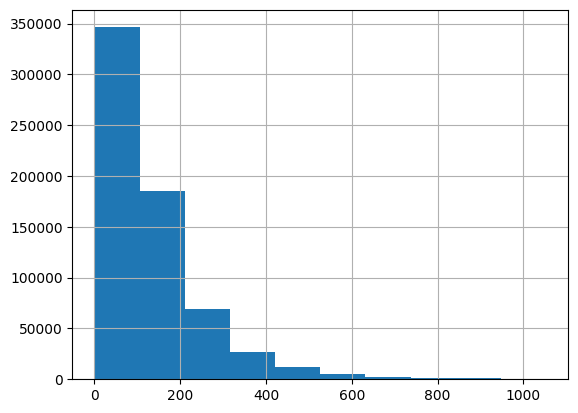

In [5]:
data_frame['Text_len'].hist()

In [6]:
max_text_len = np.percentile(data_frame['Text_len'], np.min([int(SAMPLE_SIZE / data_frame.shape[0] * 100 + 10), 100]))
max_text_len, np.sum(data_frame['Text_len'] < max_text_len)

(79.0, 259870)

In [7]:
data_frame = data_frame[data_frame['Text_len'] < max_text_len]

In [8]:
data_frame

,Label,Text,Text_len
3,3,Got a letter in the mail last week that said D...,53
5,4,Top notch doctor in a top notch practice. Can'...,62
6,4,Dr. Eric Goldberg is a fantastic doctor who ha...,67
8,1,Wing sauce is like water. Pretty much a lot of...,60
12,3,I drove by yesterday to get a sneak peak. It ...,73
...,...,...,...
649993,4,We had Jason and the guys do our yard clean up...,75
649994,4,"Wow, what a warm hearted honest and nice hard ...",35
649995,4,I had a sprinkler that was gushing... pipe bro...,61
649996,0,Phone calls always go to voicemail and message...,16


In [9]:
a = []
for i in data_frame['Label'].unique():
    a.append(data_frame[data_frame['Label']==i][:(SAMPLE_SIZE // len(data_frame['Label'].unique()))])
data_frame = pd.concat(a)
data_frame = data_frame.sample(frac=1)
data_frame = data_frame.reset_index()
del data_frame['index']

In [10]:
with open(f'data{SAMPLE_SIZE}_df.pic', 'wb') as f: 
    pickle.dump(data_frame, f)

## check sample

In [11]:
# with open(f'data{SAMPLE_SIZE}_df.pic', 'rb') as f:
#     data_frame = pickle.load(f)

In [12]:
data_frame

,Label,Text,Text_len
0,1,Normally my fav place however now have new peo...,67
1,3,Love this place. My daughter loves it as well....,40
2,2,"Hotel is older, however, the price was right a...",32
3,3,cool little pub just down the street from the ...,28
4,1,restaurant week menu not great. very small sal...,58
...,...,...,...
199995,1,This Starbucks is pretty slow and unfriendly. ...,63
199996,0,I will never get gas at this disgustingly dirt...,55
199997,3,I've just arrived back from having the BBQ pul...,72
199998,4,It's Vegas. Ain't nothing wrong with getting h...,53


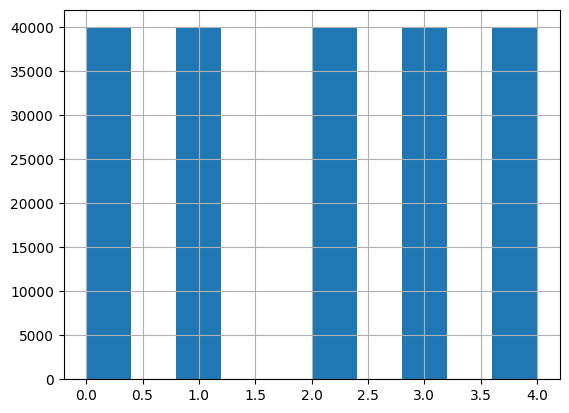

In [13]:
data_frame['Label'].hist();

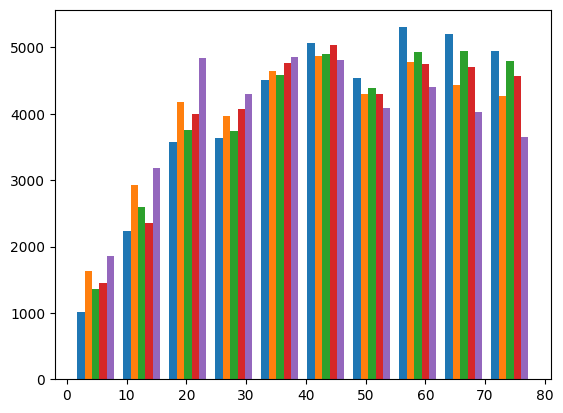

In [14]:
plt.hist([data_frame[data_frame['Label']==i]['Text_len'] for i in data_frame['Label'].unique()]);

# Backbone

In [15]:
TRANSFORMER_NAME = 'facebook/bart-base'
MODEL_NAME = 'facebook_bart_base'

Load pretrained model from Hugging Face (or some other model repository if it's more convenient). Model should be trained on Feature Extraction task.

In [16]:
backbone = transformers.TFAutoModel.from_pretrained(TRANSFORMER_NAME)

All PyTorch model weights were used when initializing TFBartModel.

All the weights of TFBartModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartModel for predictions without further training.


Load tokenizer to be used with the model

In [17]:
tokenizer = transformers.AutoTokenizer.from_pretrained(TRANSFORMER_NAME)

In [18]:
backbone.summary()

Model: "tf_bart_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBartMainLayer)     multiple                  139420416 
                                                                 
Total params: 139420416 (531.85 MB)
Trainable params: 139420416 (531.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Feature extraction

Since we will not be training the backbone, extract features from your dataset.

Tokenize all your sequences. Truncate/pad the squences for convenience. If the sequences are too large to be stored in memory, lazily save them on disk.

In [19]:
tokenize_seq = []

for text in tqdm.tqdm(data_frame['Text']):
    tokenize_seq.append(tokenizer(text)['input_ids'])

  0%|          | 0/200000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1810 > 1024). Running this sequence through the model will result in indexing errors


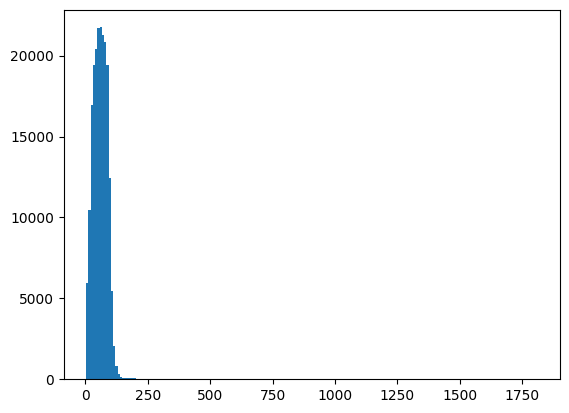

In [20]:
plt.hist([len(tok) for tok in tokenize_seq], 200);

In [21]:
num_token = int(np.percentile([len(tok) for tok in tokenize_seq], 99))
num_token

119

In [22]:
X = tf.keras.preprocessing.sequence.pad_sequences(
    tokenize_seq,
    maxlen=num_token,
    truncating='post',
    padding='post',
    value=tokenizer.pad_token_id)

In [23]:
text_dataset = tf.data.Dataset.from_tensor_slices(X).batch(64)

Run the backbone on the sequences and save the extracted features. The extracted features should be a vector containing information about the whole text. If the features are too large to be stored in memory, lazily save them on disk.

In [24]:
features = []
for data in tqdm.tqdm(text_dataset):
    features.extend(tf.math.reduce_mean(backbone(data).last_hidden_state, axis=1))

  0%|          | 0/3125 [00:00<?, ?it/s]

In [25]:
features = np.array(features)

In [26]:
features.shape

(200000, 768)

In [27]:
with open(f'fetures_data/{MODEL_NAME}_features_ar_data{SAMPLE_SIZE}.pic', 'wb') as f:
    pickle.dump(features, f)

In [28]:
features.shape

(200000, 768)

In [29]:
features[0].shape

(768,)

# Prepare train/test data

In [30]:
# with open(f'fetures_data/{MODEL_NAME}_features_ar_data{SAMPLE_SIZE}.pic', 'rb') as f:
#     features = pickle.load(f)

In [31]:
# features = X

In [32]:
y = np.array(data_frame['Label'])

Split your data (extracted features and labels) into train and test subsets.

In [33]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(features, y)

Prepare `tf.data.Dataset` or some other way for the data to be used during training.

In [34]:
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset)).batch(64)
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset)).batch(64)

# Build the model

Build a simple model. The model should accept an extracted feature vector and return a vector of class logits (or probabilities). Model should only have a couple (or even 1) layer with weights.

In [35]:
inputs = tf.keras.layers.Input(features.shape[1], name='input', dtype=tf.int32)
x = tf.keras.layers.Dense(512, name='Dense1', activation='relu')(inputs)
x = tf.keras.layers.Dense(len(data_frame['Label'].unique()), name='prediction')(x)
model = tf.keras.Model(inputs=inputs, outputs=x, name='MyModel')

In [36]:
model.summary()

Model: "MyModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 768)]             0         
                                                                 
 Dense1 (Dense)              (None, 512)               393728    
                                                                 
 prediction (Dense)          (None, 5)                 2565      
                                                                 
Total params: 396293 (1.51 MB)
Trainable params: 396293 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Compile the model. Choose loss and metrics.

In [37]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics='accuracy')

# Train the model

In [47]:
model.fit(train_dataset, validation_data=test_dataset, epochs=10)

Epoch 1/10
2344/2344 [==============================] - 10s 4ms/step - loss: 0.7613 - accuracy: 0.6882 - val_loss: 1.5234 - val_accuracy: 0.4636
Epoch 2/10
2344/2344 [==============================] - 10s 4ms/step - loss: 0.7251 - accuracy: 0.7055 - val_loss: 1.5834 - val_accuracy: 0.4643
Epoch 3/10
2344/2344 [==============================] - 10s 4ms/step - loss: 0.6928 - accuracy: 0.7199 - val_loss: 1.6338 - val_accuracy: 0.4658
Epoch 4/10
2344/2344 [==============================] - 10s 4ms/step - loss: 0.6642 - accuracy: 0.7312 - val_loss: 1.6872 - val_accuracy: 0.4645
Epoch 5/10
2344/2344 [==============================] - 10s 4ms/step - loss: 0.6384 - accuracy: 0.7428 - val_loss: 1.7603 - val_accuracy: 0.4633
Epoch 6/10
2344/2344 [==============================] - 10s 4ms/step - loss: 0.6177 - accuracy: 0.7506 - val_loss: 1.8467 - val_accuracy: 0.4581
Epoch 7/10
2344/2344 [==============================] - 11s 5ms/step - loss: 0.5967 - accuracy: 0.7584 - val_loss: 1.9341 - val_ac

# Evaluation

Evalute the model on test data.

In [49]:
predict = model.predict(X_test).argmax(axis=-1)

1563/1563 [==============================] - 1s 941us/step


Plot confusion matrix.

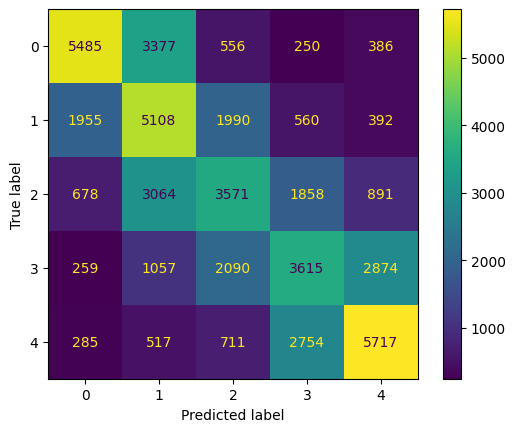

In [48]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, predict)

Write a function to classify a piece of text.

In [55]:
def classify_text(text: str) -> tuple[int | str, np.ndarray]:
    '''Classifes the given `text` using the trained model.

    Arguments:
        text: text to be classified

    Return:
        The assigned label and probabilites of all labels'''
    tokens = [tokenizer(text)['input_ids']]
    text_dataset = tf.data.Dataset.from_tensor_slices(tokens).batch(1)

    for data in text_dataset:
        features = tf.math.reduce_mean(backbone(data).last_hidden_state, axis=1)
    predict = scipy.special.softmax(model.predict(features, verbose=0))
    return predict[0].argmax(), predict[0]

Evaluate the model on text not present in training and test data (come up with the text yourself). Try to get an input for each class.

In [65]:
i = 6
text = data_frame.iloc[i]['Text']
text = "very tasty"
print(text)
pr = classify_text(text)


print(data_frame.iloc[i]['Label'], pr[0])

very tasty
4 4


# Bonus

Write a function that computes word impact on text label. 

In [62]:
def get_words_impact(text: str) -> list[tuple[str, np.ndarray]]:
    '''Determines word impact on text label.

    Arguments:
        text: Sample text to be used for computation.

    Returns:
        A list of pairs: the word and vector of probability changes for each class'''
        
    full_text_pr = classify_text(text)[1]
    pr = {}
    spl_text = text.split()
    for i, word in enumerate(spl_text):
        txt = ' '.join(spl_text[:i] + spl_text[i+1:])
        pr[f'{word}'] = full_text_pr - classify_text(txt)[1]
    return pr

Try to find out words that make text have a specific label.

In [63]:
i = 4
text = data_frame.iloc[i]['Text']
# text = "tasty"
print(text)
pr = get_words_impact(text)

restaurant week menu not great. very small salad and three not\nvery large scallops for main course. service barely mediocre.\nserver never asked if we wanted coffee or  whatever for dessert. presented check without being asked for it. runners\nhad no idea who got any of the courses. server never asked how\nthe food was. had much better experience at previous visit.


In [64]:
pr

{'restaurant': array([ 9.4865024e-02, -9.7632281e-02,  2.7672201e-03,  1.4561670e-12,
         1.9155808e-23], dtype=float32),
 'week': array([ 9.6229720e-01, -9.6367943e-01,  1.3821960e-03,  1.4559801e-12,
         1.8966816e-23], dtype=float32),
 'menu': array([ 2.5427574e-01, -2.5290555e-01, -1.3702158e-03,  1.4561642e-12,
         1.0419266e-23], dtype=float32),
 'not': array([-1.1032164e-02,  8.3308471e-03,  2.7013498e-03,  1.4521635e-12,
        -4.5007885e-14], dtype=float32),
 'great.': array([ 7.2134459e-01, -5.1994801e-01, -2.0139651e-01,  4.5716176e-13,
        -1.0335861e-23], dtype=float32),
 'very': array([ 3.8007283e-01, -3.8218659e-01,  2.1137015e-03, -5.4443559e-12,
        -8.8430045e-23], dtype=float32),
 'small': array([ 9.8255599e-01, -9.8088717e-01, -1.6687475e-03,  1.4430984e-12,
        -9.4893788e-21], dtype=float32),
 'salad': array([ 5.1701844e-02, -5.4400440e-02,  2.6985237e-03,  1.4561408e-12,
        -4.6529168e-21], dtype=float32),
 'and': array([ 1.03900

In [46]:
a = [1, 2, 3]
b = [2 , 3, 4]
a + b

[1, 2, 3, 2, 3, 4]